<a href="https://colab.research.google.com/github/bpblakely/Networking_Class/blob/main/Root_Insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes Before Reading

The order of information presentation does not exclude prior sections from involving work from a future section. Particullarly, in preprocessing we do some basic dimensionality reduction, which will get talked about in the dimensionality reduction section. Likwise decisions of preprocessing steps determined by data exploration.

Before we do anything, to get this code working well in a Google Colab notebook, lets read the data from Google Drive

In [1]:
from google.colab import drive as mountGoogleDrive 
mounted_drive_directory = '/content/mountedDrive'
mountGoogleDrive.mount(mounted_drive_directory)

Mounted at /content/mountedDrive


# **Preprocessing**

I wrote the preprocessing code as a completely seperate python file, which is to expected to be used before analyzing the test data. If time permitted it, I would ideally condense this into a class which can quickly manipulate a single, or multiple files

##Algorithmic Complexity:    ![formula](https://render.githubusercontent.com/render/math?math=\mathcal{O}(n))
> *For reference, if rendering fails: O(n)*

This is the complexity to preprocess one unzipped file. The actual preprocessing code attempts to unzip all data before use, this is for ease of use when parallelizing the code. 


##Features of preprocessing


*   Works given the work_sample directory
*   Easily tune feature extraction parameters by changing a global variable
*   Automatically unzips your data and renames the data folder, *if it's not already done*
*   Finishes file processing in **a single for loop** (All other bulk processing is vectorized)
*   **Runs in parallel**
*   Importantly, you don't need to understand anything to use it, just give the directory and run the file


## Code

In [ ]:
import pandas as pd
import numpy as np
import zipfile
import glob
import os
from multiprocessing import Pool
import time

# Global Variables
directory = mounted_drive_directory + '/MyDrive/work_sample/' # data directory

# Training or Test Data
train_data = True # Set to False to run on test data

# Feature parameters
turning_threshold = 60 # angle theta
turning_time_threshold = 120 # 120 seconds (2 minutes)
sliding_window_time = 3 # amount of time (seconds) to consider for our sliding window averages
stop_speed_threshold = .1 # less than .1 meters/second to be a stop

# Simplify some variables to make the code easier to read and write
def read_trip_data(filename):
    # Input: filename (str) of trip data
    # Output: DataFrame (with renamed columns)
    return pd.read_csv(filename).rename({'time_seconds':'time','speed_meters_per_second':'speed','heading_degrees':'bearing'},axis=1)

# Feature extraction has complexity O(n)
def feature_extraction(df):
    # Input: Dataframe of trip data, which was read using read_trip_data (due to renaming columns)
    # Output: turn_count (int) and stop_count (int)
    
    # Need to change the bearing to be relative to the closest angle between 2 angles: (to make angle 5 and 355 be 10 degress apart instead of 350)
    df['relative_bearing'] = df.bearing.apply(lambda x: 360-x if x > 180 else x)

    avg_theta = []
    avg_speed = []
    turns = 0
    last_i = 0 # used to create a subset of data after we make a turn
    list_index = 0 # another pointer for list to dataframe

    # Need to iterate to build a sliding window
    for i,x in enumerate(df.time):
        # include the points own data and the last 2 seconds of data for a 3 second window
        subset= df.loc[(df.time <= x) & (df.time > x - sliding_window_time)]
        avg_theta.append(subset.relative_bearing.mean())
        avg_speed.append(subset.speed.mean())
        
        # COMPUTE TURNS (in the same loop to save time)

        # Create a subset containing all data points after the last turn was made AND within turning_time_threshold seconds (2 minutes)
        turn_subset = df.iloc[last_i:i] 
        turn_subset = turn_subset.loc[turn_subset.time >= (x - turning_time_threshold)]
        # Increasing turning_time_threshold will detetect slower, longer turns, whereas lowering will find quick, immediate turns

        if turn_subset.first_valid_index():
            list_index = turn_subset.first_valid_index() # need a new index to use to connect the correct index for dataframe with the index of the list we are building
        
        # Comparing avg_theta allows us to only consider the turns after being smoothed over 3 second intervals for better estimation
        if any(abs(avg_theta[list_index:i]-df.iloc[i].relative_bearing) > turning_threshold):  
            last_i = i
            turns += 1 
    
    df['avg_bearing'] = avg_theta
    df['avg_speed'] = avg_speed
    
    # COMPUTE STOPS
    stops = 0
    idx = df.index[df.avg_speed < stop_speed_threshold]
    if len(idx) > 0:
        stops += 1 # at least 1 so far
        diffs = np.diff(idx) # compute distances between each index, to find where we have no consecutive indicies, which indicate a different stop
          # An advantage to this approach is that we can consider any amount of non-consecutive points before we break a chain of stops.
            # (change 'diffs > 1' to any number)
        unique_indx = np.argwhere(diffs > 1).ravel()
        stops += len(unique_indx)
    
    return turns,stops

def process_parallel(filename):
    # Input: filename of trip data
    # Output: (filename, # turns, # stops) (as a Tuple)
    df = read_trip_data(filename).dropna() # Might miss some stops due to dropping NA immediately
    df.reset_index(drop=True,inplace=True)
    turns, stops = feature_extraction(df)
    return filename.split('\\')[-1], turns, stops # create a reference of filename to extracted features to be safe
    
if __name__ == "__main__":
    # used for path building so we can use the same code to easily preprocess both test and training data
    if train_data:
        text = 'train'
        folder_name = "trip_data"
    else: 
        text = 'test'
        folder_name = "work_sample_test_trips"
        
    # extract the data from the zip file and rename if you havent
    if not os.path.isdir(directory+'trip_data_' + text):
        if os.path.isdir(directory+'trip_data'):
            os.rename(directory+'trip_data',directory+'trip_data_' + text) # if its extracted and not renamed, just rename it
        else:
            with zipfile.ZipFile(directory + "trip_data_"+text+".zip", "r") as zipObj:
                zipObj.extractall(directory)
            if os.path.isdir(directory+folder_name):
                os.rename(directory + folder_name,directory+'trip_data_'+text)
            else:
                raise ValueError("Incorrect Data Path or corrupted zip file, could not find extracted trip_data folder")
            
    files = [file for file in glob.glob(directory+'trip_data_'+ text +'/*.csv')]
    
    # process in parallel
    start_time = time.time()
    with Pool() as pool:
        results = pool.map(process_parallel,files)
    print(f"Time to preprocess in parallel {len(files)} files: {time.time() - start_time} seconds")

    results = pd.DataFrame(results,columns = ['filename','turns', 'stops'])
    model_df = pd.read_csv(directory + 'model_data_'+ text +'.csv')
    model_df = model_df.merge(results, on=['filename'])
    
    if train_data:
    # put the y variable as the last column for clarity
        cols = list(model_df.columns)
        cols.insert(len(cols), cols.pop(cols.index('y')))
        model_df = model_df.loc[:, cols]
        del cols
    
    model_df.to_csv(directory + 'model_data_'+ text +'_modified.csv',index=False)
    
    # process in serial for time comparison
    start_time = time.time()
    results = [process_parallel(file) for file in files]
    print(f"Time to preprocess in serial {len(files)} files: {time.time() - start_time} seconds")
    # Done at the end so I don't have to wait 100 years to continue

Time to preprocess in parallel 1000 files: 823.7210640907288 seconds
Time to preprocess in serial 1000 files: 965.6807601451874 seconds


**Note** 

Google Colab notebooks only have 4 cores so the difference isn't extreme. However, on my local computer (16 cores) this code finish in 1 minute instead of 16 minutes

![](https://i.imgur.com/qQyvSom.png)

## Parallelization of Preprocessing

The preprocessing of all the files is done in parallel. This is because it's  designed with scalability in mind. This code can easily be executed on a cloud server or cluster of hundreds of CPUs and finish executing in milliseconds.

---

In order to fit everything into one for loop, I had to build a more complex solution, which does impact the readability of the code. I could make this much easier to read where the complexity becomes O(2n).

Most of the code in the preprocessing will be explained later in data exploration and feature creation.

**Note**

I don't have time to elaborate on every decision made and their computation implications (such when vectorization is used and why or computation of distance index vectors and why it's being used). Hopefully my comments in the code are enough to understand, but if not then they make for great talking points in an interview

# **Data Exploration**

This section is going to be very involved with the Feature Creation section. Most of this code was written before the data extraction code, thus some different preprocessing steps will be done to show my thoughts that lead my decisions.

**Disclaimer**: When using pandas, I am fully aware to that when you create a new column you should use pandas.DataFrame.assign(column_name = data).

However, since I am also being evaluated on readability, I decided to stick with simple, easy to read syntax ([which isn't always the best thing to do](https://www.dataquest.io/blog/settingwithcopywarning/). 

## Simple Plot of Vehicle Movement

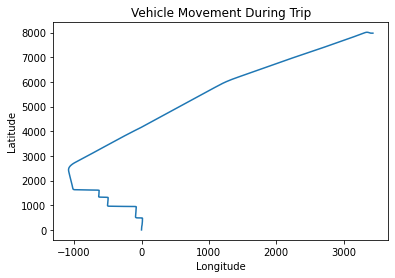

In [ ]:
import matplotlib.pyplot as plt
import math
df = read_trip_data(r'/content/mountedDrive/MyDrive/work_sample/trip_data_train/0001.csv').dropna()
df.reset_index(drop=True,inplace=True)

dist_traveled = [0]  # distance traveled (in meters) from the last time point

for i in range(1,len(df)):
    # lets use the average of the 2 time points as the true speed between each second in the time series
    t = abs(df.iloc[i].time - df.iloc[i-1].time) # difference in time
    s = (df.iloc[i].speed + df.iloc[i-1].speed)/2 # average speed

    dist_traveled.append(t*s)
    
df['distance'] = dist_traveled
#df = df.assign(df = df['distance'].cumsum()) # distance is in meters

df['x'] = (df.bearing.apply(lambda x: math.cos(math.radians(x))) * df.distance).cumsum()
df['y'] = (df.bearing.apply(lambda x: math.sin(math.radians(x))) * df.distance).cumsum()


df.reset_index(drop=True,inplace=True)

plt.plot(df.x,df.y)
# It's not really lat and long, but is easily described using the same idea
plt.xlabel('Longitude') 
plt.ylabel('Latitude')
plt.title('Vehicle Movement During Trip')
plt.show()

## Relative Bearing Caveat

You can see in the data that the bearing ranges from [0,360)

In [ ]:
df.bearing.describe()

count    625.000000
mean      91.468704
std       60.309695
min        0.028219
25%       55.450955
50%       79.534608
75%       95.358634
max      356.250950
Name: bearing, dtype: float64

**This is problematic for computing a turn!**

![](https://i.imgur.com/MXiiRWS.png)


When comparing $5 \theta$ and $355 \theta$, we should only have turned 10 degrees, not 350! 

---

**Solution**

In order to solve this problem, we need to create a *relative bearing*, where the values range from [0,180]. 

This is angle of shortest path relative to the origin, which is what we will use to calculate turns

In [ ]:
df['relative_bearing'] = df.bearing.apply(lambda x: 360-x if x > 180 else x)

## More Plots

First we need to do **a lot** of work to get this data into a beautiful plot


### Step 0: Reprocess the data 

Reprocess the data so we can actually access important computed data

In [ ]:
df['relative_bearing'] = df.bearing.apply(lambda x: 360-x if x > 180 else x)

avg_theta = []
avg_speed = []
turns = []
last_i = 0 # used to create a subset of data after we make a turn
list_index = 0 # another pointer for list to dataframe

# Need to iterate to build a sliding window
for i,x in enumerate(df.time):
    # include the points own data and the last 2 seconds of data for a 3 second window
    subset= df.loc[(df.time <= x) & (df.time > x - sliding_window_time)]
    avg_theta.append(subset.relative_bearing.mean())
    avg_speed.append(subset.speed.mean())
    
    # compute turns in the same loop to save time

    # Create a subset containing all data points after the last turn was made AND within turning_time_threshold seconds (2 minutes)
    turn_subset = df.iloc[last_i:i] 
    turn_subset = turn_subset.loc[turn_subset.time >= (x - turning_time_threshold)]
    # Increasing turning_time_threshold will detetect slower, longer turns, whereas lowering will find quick, immediate turns

    if turn_subset.first_valid_index():
        list_index = turn_subset.first_valid_index() # need a new index to use to connect the correct index for dataframe with the index of the list we are building
    
    # Comparing avg_theta allows us to only consider the turns after being smoothed over 3 second intervals for better estimation
    if any(abs(avg_theta[list_index:i]-df.iloc[i].relative_bearing) > turning_threshold):  
        last_i = i
        turns.append(last_i)
# A Turn is defined as: When the avg relative angle in the last 3 seconds exceeds any previous relative angle after the last turn was made
# This will catch things such as very slow turns (and can misclassify in certain cases)
# This is being used because it is very fast to compute and is a fairly strong solution, despite not being the best

df['avg_bearing'] = avg_theta
df['avg_speed'] = avg_speed

stops = 0
idx = df.index[df.avg_speed < .1]
if len(idx) > 0:
    stops += 1 # at least 1 so far
    diffs = np.diff(idx) # compute distances between each index, to find where we have no consecutive indicies, which indicate a different stop
      # An advantage to this approach is that we can consider any amount of non-consecutive points before we break a chain of stops.
        # (change 'diffs > 1' to any number)
    unique_indx = np.argwhere(diffs > 1).ravel()
    stops += len(unique_indx)

### Step 1: Turn Indexing 

Let's start by adding a column to our dataframe which indicates if a timepoint was attributed a turn

In [ ]:
t = []
for i in range(len(df)):
    if i in turns:
        t.append(True)
    else:
        t.append(False)
df['turn'] = t

### Step 3: Color Mapping

Next let's create a color mapping for speed. This way we can simply color the line to show the speed, which lets us easily display 3 dimensions in only 2.

In [ ]:
colors=[]
for x in df.avg_speed:
    if x < .1: colors.append('black')
    elif x < 5: colors.append('firebrick')
    elif x < 10: colors.append('gold')
    elif x < 15: colors.append('forestgreen')
    elif x < 25: colors.append('royalblue')
    else: colors.append('navy')
df['color'] = colors

### Step 4: Create Continuous Segmentation

Next we do some magic to create a continuous graph of different colored line segments

In [ ]:
myf = df.copy()
myf['change'] = myf.color.ne(myf.color.shift().bfill()).astype(int)
myf['subgroup'] = myf['change'].cumsum()
myf.index += myf['subgroup'].values

first_i_of_each_group = myf[myf['change'] == 1].index
for i in first_i_of_each_group:
    myf.loc[i-1] = myf.loc[i]
    myf.loc[i-1, 'subgroup'] = myf.loc[i-2, 'subgroup']
myf.drop('change', axis=1, inplace=True)
myf.sort_index(inplace=True)

# Create duplicate indexes at each subgroup border to ensure the plot is continuous.
myf.index -= myf['subgroup'].values

### Step 5: **The Plot!**

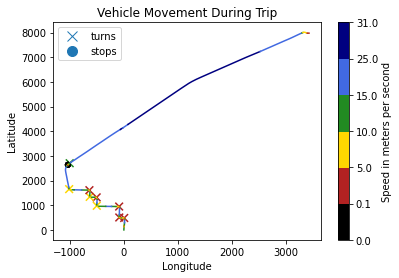

In [ ]:
import matplotlib
import matplotlib.lines as mlines
bounds = [0, .1, 5, 10, 15, 25, df.speed.max()] # boundries for color bar
fig, ax = plt.subplots()

for k, g in myf.groupby('subgroup'):
    g[['x','y']].plot(ax=ax,x='x', y='y', color=g['color'].values[0],legend=None)
stop_df = myf.loc[myf.avg_speed < .1]

# plot the turns with marker 'x'
plt.scatter(myf.loc[myf.turn]['x'].values,myf.loc[myf.turn]['y'].values,s = 60,marker='x',c = myf.loc[myf.turn]['color'].values,label = 'turns')
# plot stops with marker 'o'
plt.scatter(stop_df['x'].values,stop_df['y'].values,s = 25,marker='o',c = stop_df['color'].values,label='stops')

# need to do some weird stuff to get around pandas plotting flooding my legend (nothing else seemed to work)
x_marker = mlines.Line2D([], [], marker='x', linestyle='None', markersize=10, label='turns')
o_marker = mlines.Line2D([], [], marker='o', linestyle='None', markersize=10, label='stops')
ax.legend(handles=[x_marker, o_marker])

cmap = matplotlib.colors.ListedColormap(['black','firebrick','gold','forestgreen','royalblue','navy'])
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm,ax=ax,boundaries= bounds,spacing='uniform',ticks=bounds,label='Speed in meters per second')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Vehicle Movement During Trip')

plt.show()

Just to make it easier to see (view image in new tab for higher resolution):

![](https://i.imgur.com/HmGVXfk.png)

### Animating the plot

We can easily animate this plot to make a gif of the data moving over time. This does take a fair amount of time to compute.

This code is less important, it's more so just the cherry on top. See the misc code section at the end.

---

**First Animation**

> This animation is the first animation I made, which animates the every single data point through the 0001.csv trip! This was my first animation, which was before I had the super nice looking color bar.

> If I uploaded the gif plots, colab will remove them after the session ends. So the best I can do is provide an imgur link [here is the link](https://i.imgur.com/ljAQuL7.mp4)

**Second Animation**

> This animation was on the same file, but half as much data so the computation would finish faster. This animation has the updated legend and color bar. [Here is the link](https://i.imgur.com/eX0dXCQ.mp4)

# **Feature Creation**

## Creating Events

The problem statement says to consider timepoints within 3 seconds as one event.

**Creating 3 second long Events**

> We use a moving average which considers events within 3 seconds of the current timepoint. The **average speed** and **average bearing** is computed for each data point. 

These columns represent the event which each timepoint belongs to. These columns are used for computations with resepect to events.


## **Turning**

The event of turning is an event which spans more than 3 seconds. Thus, we need to determine a turn on a collection of events.

---

Also notice that turns also happen at lower speeds, however I didn't want to make this part of turning criteria incase we overlook some dangerous fast turns.

However, it would be easy to set a fast turn threshold which could create a third new feature that classifies a turn as dangerous 

### Computation of a Turn

Consider a time point (a row of data), **x**, which has an average speed and average bearing.

1. Select a subset of previous timepoints based on the criteria
> Timepoints from **at most 2 minutes ago** *and* timepoints that happened **after the last turn**

2. Compute the absolute difference of average bearing between x and the subset of timepoints average bearings

3. If any of the differences > 60, then this timepoint x is a turn.

4. Update the pointer, last_index, to the current index value (index of x)
> This way we can correctly select our subset of data after turning



### Explanation of Decisions Made

The biggest question you might have is: *Why only consider timepoints after the last turn?*

> Doing this let's us create a very fast and accurate computation. It gives a very accurate description of the **number of turns** in a trip.

> We only care that a turn happened, so we don't want to consider all events which a turn was taking place nor do we really care about the exact time a turn happened. 

By only considering data after the last turn was made, we require the next turn to be at least 60 degrees different from the last turn. This lets us easily detect multiple sharp turns without misclassifying them.

 We also handle noisy data (a random bad value for 1 time point) since we are considering bearings which are an average of bearings over the last 3 seconds

 ---

 Code is built into the preprocessing code

## **Stops**

Stops are computed in a very simple, efficient manor.

### Computation of a Stop

1. Consider a subset of all events with average speed < .1 speed
2. Count the number of non-consecutive indicies in the subset
> So if we were stopped for x = 1,2,3 then we moved and stopped again on x= 8,9,10

  > > Subset = [1,2,3,8,9,10]

  > > We will have only stopped twice, since there are 2 non-consecutive indicies


### Explanation of Decisions Made

This approach allows us to easily define a number of non-consecutive events to consider outside of our stopping speed threshold to conisder.

To elaborate, if someone is in stop very slow stop and go traffic, moving 3 inches forward is basically the same as being stopped in the same spot. In that case we might want to consider 3 events where the speed is above the threshold before we decide it isnt a break.

Example:

> stopped x = [1,2,3,4], driving x= [5], stopped = [6,7,8,9,10]

> subset = [1,2,3,4,6,7,8,9,10]

With a window of 1 non-consecutive index to count as the same stop, we can classify this subset as 1 stop instead of 2 seperate stops

---


This code is also in the preprocessing code

# Dimensionality Reduction

## Simple Analysis

Let's first just take a generic look at our dataset and see if there is any obviously bad data

In [60]:
# First let's reinstance our Google Colab, so you don't need to run all previous code to run this code (no need to create features again)
import pandas as pd
import numpy as np
# the rest will be used later
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

directory = mounted_drive_directory + '/MyDrive/work_sample/'

In [14]:
df = pd.read_csv(directory+ '/model_data_train_modified.csv')
df.describe() 

,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,turns,stops,y
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000
mean,4.984873,9977.840571,31346.310636,0.001000,4.974000,10.053000,1.0,8.861258e+08,8.845462e+03,8.861258e+08,4.976221,7.670000,4.763000,0.310000
std,0.997816,990.773528,3112.606836,0.000010,1.556839,3.015507,0.0,1.957633e+10,8.087624e+04,1.957633e+10,1.560448,4.255256,4.282893,0.462725
min,2.116270,7193.513346,22599.088680,0.000971,1.000000,2.000000,1.0,8.550778e-03,4.504803e-08,4.320016e+00,0.825435,0.000000,0.000000,0.000000
25%,4.324381,9314.992298,29263.911371,0.000993,4.000000,8.000000,1.0,7.959224e+02,1.320425e-01,8.009469e+02,3.980613,5.000000,2.000000,0.000000
50%,4.990547,9961.242569,31294.166476,0.001001,5.000000,10.000000,1.0,2.294823e+04,2.744109e+00,2.295354e+04,4.988078,7.000000,4.000000,0.000000
75%,5.675052,10678.569893,33547.716728,0.001007,6.000000,12.000000,1.0,6.395295e+05,7.829274e+01,6.395340e+05,6.022663,10.000000,7.000000,1.000000
max,8.819192,12819.907634,40274.927643,0.001035,10.000000,22.000000,1.0,6.069658e+11,1.572134e+06,6.069658e+11,10.327562,33.000000,39.000000,1.000000


In [15]:
df.feature2.describe() # last print was too wide for 1 screen

count      1000
unique        1
top       False
freq       1000
Name: feature2, dtype: object

We can clearly see that feature2 and feature10 do absolutely nothing as they are just the same value every time. 

We must confirm this is the case in the test data, the code is the same as above and omitted, but the outcome is basically the same. The only difference is that the test data feature2 has 1 row with a different value.

We also need to drop the filename because without dropping it our matrix of features won't be a proper vector space. More intuitively, a filename should have no importance about the trips classification.

We are just going to drop these three columns immediately.



In [16]:
df.drop(['filename','feature2','feature10'],axis=1,inplace=True)

We need to **standardize** and **split up** our data into training and testing set. If we didn't do this before ranking feature importance, then we would introduce bias. We randomly shuffle the data before selecting the training and test subsets.

Training Data: 75% of data

Test Data: 25% of data 

In [114]:
# making this a function so we can easily call it if we decide to drop features in the future
def split_and_norm(df):
  features = np.array(df.iloc[:,:-1])
  labels = np.array(df.iloc[:,-1])

  X_train,X_test,y_train,y_test = train_test_split(features,labels,test_size=.25,random_state=5)

  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  return features, labels, X_train, X_test, y_train, y_test # a little bit messy

features, labels, X_train, X_test, y_train, y_test = split_and_norm(df)

## Feature Importance

Ranking of the importance of features. This gives us more insight into our data. I will be using the feature imporatnce of a random forest. The parameters of the random forest were selected in the classification sectio

Feature ranking:
1. feature9 (0.22930353742120518)
2. feature7 (0.19640103243753684)
3. feature4 (0.09417616987039193)
4. feature14 (0.06434093394483503)
5. feature6 (0.057343575860919295)
6. feature5 (0.055965058655970935)
7. feature12 (0.053731716005379286)
8. feature11 (0.046648313913810614)
9. turns (0.046604776971300124)
10. feature13 (0.04590346504182939)
11. stops (0.04377548947361034)
12. feature1 (0.026025233671427533)
13. feature8 (0.024999349638302786)
14. feature3 (0.014781347093480682)


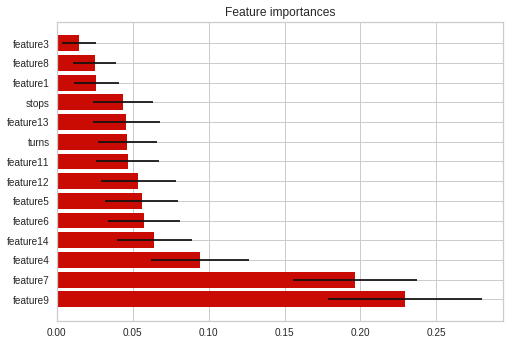

In [35]:

RF = RandomForestClassifier(n_estimators=200, max_depth=12,random_state=1,min_samples_leaf=1)
RF.fit(X_train, y_train)

importance = RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF.estimators_],axis=0)
indices = np.argsort(importance)[::-1]

# Print the feature ranking
print("Feature ranking:")
correct_column_order = [] # making nice xticks for future plot
for f in range(X_train.shape[1]):
    print(f"{f+1}. {list(df.columns)[indices[f]]} ({importance[indices[f]]})")
    correct_column_order.append(list(df.columns)[indices[f]])

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]),importance[indices],color="r", xerr=std[indices], align="center")
plt.yticks(range(X_train.shape[1]), correct_column_order)
#plt.ylim([-1, X_train.shape[1]])
plt.show()

We will explore the dropping low importance features during the classification section.


## PCA

One major benefit of PCA dimensionality reduction is that you can speed up computations by reducing dimnesions by combining features, with marginal loss in performance, but sometimes better performance.




In [115]:
from sklearn.decomposition import PCA
def test_pca(df,components):
  pca = PCA(n_components= components)
  principalComponents = pca.fit_transform(np.array(df.iloc[:,:-1]))
  columns = [f'PC {i+1}' for i in range(principalComponents.shape[1])]
  principalDf = pd.DataFrame(data = principalComponents, columns = columns)
  new_df = pd.concat([principalDf, df['y']], axis = 1)

  features_pca, labels_pca, X_train_pca, X_test_pca, y_train_pca, y_test_pca = split_and_norm(new_df)

  RF = RandomForestClassifier(n_estimators=250, max_depth=12,random_state=1,min_samples_leaf=1)
  print(f"PCA with n_components = {components}")
  #print("10-fold cross-validation mean AUC: ", np.mean(cross_val_score(RF, features_pca, labels_pca, cv=10,scoring='roc_auc')))

  RF.fit(X_train_pca, y_train_pca)
  y_pred_pca = RF.predict_proba(X_test_pca)[:,1]
  tprAtDesiredFPR,fpr,tpr = tprAtFPR(y_test_pca,y_pred_pca,.55) # this is how we evaluate the matrix later in the notebook
  print("Test set AUC: ", roc_auc_score(y_test_pca,y_pred_pca))
  print(f'Mean TPR at FPR = {desiredFPR}: {tprAtDesiredFPR*100} %')
  #print(confusion_matrix(y_test_pca, y_pred_pca))

  #print(classification_report(y_test_pca, y_pred_pca))
  #print("Test set AUC (classification): ",roc_auc_score(y_test_pca,y_pred_pca))
  #print("Accuracy: %.2f%%" % (accuracy_score(y_test_pca, y_pred_pca) * 100.0))
test_pca(df,14) # no change to features
print("-"*20)
test_pca(df,12)
print("-"*20)
test_pca(df,10)

PCA with n_components = 14
Test set AUC:  0.9205979832169805
Mean TPR at FPR = 0.55: 97.70114942528735 %
--------------------
PCA with n_components = 12
Test set AUC:  0.9206685001057754
Mean TPR at FPR = 0.55: 98.85057471264368 %
--------------------
PCA with n_components = 10
Test set AUC:  0.8484592059798323
Mean TPR at FPR = 0.55: 97.70114942528735 %


We can see that with 12 components, we actually improved our AUC, very marginally.

With the impacts being so marginal it isn't worth to use PCA in this context. It might become worth it eventually depending on the scale of the data.

It's currently not worth using because PCA adds a, currently unneeded, layer of computational obfuscation. 

When all of your features become principle components, it becomes almost impossible for a human to fully understand how one feature actually impacts the outcome of a model.

# **Classification Evaluation Criteria**

There are many ways to score the accuracy of binary classification. We will use two metrics

* **AUC under the ROC curve** (Area under the Receiver Operating Characteristics curve)
* **True positive rate at N% false positive rate**

The AUC under the ROC curve is a standard way to evaluation metric. 


**Why true positive rate at N% false positive rate?**

**Assumption:** Given that this is an insurance company and we are evaluating vehicle/car data, the *interesting* trips will probably contribute towards a customers insurance rate.

---

First let me explain true positive rate and false positive
* True Positive Rate: The **correct** number of times we predicted a trip was interesting
* False Positive Rate: The number of times we predicted an not interesting trip as interesting

---


**Customer Perspective**

From a customer point of view, you would want a very low false positive rate, since their insurance rates could get impacted due to false positive reports. Thus a customer would want N to be the smallest value possible.

**Company Perspective**

When you constrain yourself to such a low false positive rate, it makes it significantly reduces your number of true positives.

Thus the company would want N to be large, since they will correctly identify trips which show signs of bad driving, thus giving those customers higher rates. We would prefer to slightly overcharge to protect the company than to undercharge and need waste money.

---

**Picking N to meet in the middle**

As a company you want to make customers happy while making money, so we have to consider some value of N in the middle of these two extremes. 

It would be natural to think 50% is the best middleground, however a company will care more about the saftey of their financials, so long as customers aren't extremely unhappy.

With this in mind, we expect a good N value to be somewhere between: [50, 80]%

This value could be much higher depending on how impactful an 'interesting' labeled trip is towards a single persons insurance rates.

**N = 0.6** for algorithm selection process.

This is simply to reduce the number of hyper-parameters we need to tune during the selection phase. 

In [85]:
def tprAtFPR(labels,outputs,desiredFPR):
    fpr,tpr,thres = roc_curve(labels,outputs)
    # True positive rate for highest false positive rate < 0.01
    maxFprIndex = np.where(fpr<=desiredFPR)[0][-1]
    fprBelow = fpr[maxFprIndex]
    fprAbove = fpr[maxFprIndex+1]
    # Find TPR at exactly desired FPR by linear interpolation
    tprBelow = tpr[maxFprIndex]
    tprAbove = tpr[maxFprIndex+1]
    tprAt = ((tprAbove-tprBelow)/(fprAbove-fprBelow)*(desiredFPR-fprBelow) 
             + tprBelow)
    return tprAt,fpr,tpr


desiredFPR = 0.6 # using this

# **Classification**

## Random Forest Classification

I've used random forest for binary classfication [in the past](https://github.com/bpblakely/Email-Spam-Classification-Project) and it worked very well, so let's start off by testing that. I'll show some extra evaluation metrics just for sake of completeness.



10-fold cross-validation mean AUC:  0.9158952781673679
Test set AUC:  0.927226570763698
[[157   6]
 [ 25  62]]
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       163
           1       0.91      0.71      0.80        87

    accuracy                           0.88       250
   macro avg       0.89      0.84      0.86       250
weighted avg       0.88      0.88      0.87       250

0.8379169311049997
Accuracy: 87.60%
Mean TPR at FPR = 0.55: 97.70114942528735 %


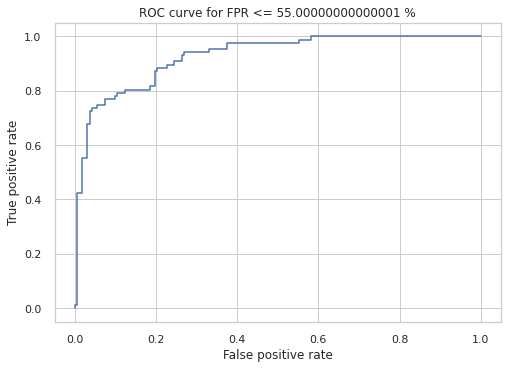

In [109]:
RF = RandomForestClassifier(n_estimators=250, max_depth=12,random_state=1,min_samples_leaf=1)

print("10-fold cross-validation mean AUC: ", np.mean(cross_val_score(RF, features, labels, cv=10,scoring='roc_auc')))

RF.fit(X_train, y_train)
y_pred = RF.predict_proba(X_test)[:,1]
print("Test set AUC: ", roc_auc_score(y_test,y_pred))
y_pred_class =  RF.predict(X_test) # rounding our probabilities to 0 or 1 for classification
print(confusion_matrix(y_test, y_pred_class))

print(classification_report(y_test, y_pred_class))
print(roc_auc_score(y_test,y_pred_class))
print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred_class) * 100.0))

tprAtDesiredFPR,fpr,tpr = tprAtFPR(y_test,y_pred,desiredFPR)

print(f'Mean TPR at FPR = {desiredFPR}: {tprAtDesiredFPR*100} %')

plt.plot(fpr,tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'ROC curve for FPR <= {desiredFPR * 100} %')    
plt.show()

Looks pretty nice, lets see if we can optimize our hyper-parameters by a simple double for loop

150 4 0.9058438522674148
150 12 0.9130902290790088
150 20 0.9129032258064516
200 4 0.9053763440860216
200 12 0.9134174848059841
200 20 0.9133707339878446
250 4 0.905750350631136
250 12 0.9141654978962132
250 20 0.9162926601215521
300 4 0.9057035998129969
300 12 0.9152875175315567
300 20 0.9164562879850398
350 4 0.9054230949041606
350 12 0.9151472650771388
350 20 0.9163160355306219
400 4 0.9056568489948574
400 12 0.9152407667134174
400 20 0.9166432912575969
450 4 0.9064048620850865
450 12 0.9149602618045816
450 20 0.9158017765310893


0.9166432912575969

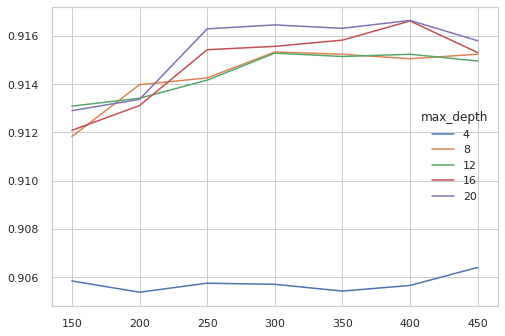

In [95]:
data = []
for i in range(150,500,50):
    for j in range(4,24,4):
        RF = RandomForestClassifier(n_estimators= i, max_depth= j,random_state=1,min_samples_leaf=1)
        score = np.mean(cross_val_score(RF, features, labels, cv=10,scoring='roc_auc'))
        if j%8: print(i,j,score) # do less printing
        data.append([i,j,score])

brute = pd.DataFrame(data,columns=['estimators','max_depth','roc_auc'])

import matplotlib.pyplot as plt
for k,g in brute.groupby('max_depth'):
    plt.plot(g.estimators.values,g.roc_auc.values,label=str(k))
plt.legend(title='max_depth')
plt.plot()
max(brute.roc_auc)

We can see the the performance is relatively the same for most n_estimators and depths>4. Odds are that this graph will look different for different shuffles of the data, so let's take it with a grain of salt.

Let's pick n_estimators = 250, and max_depth = 8 to save on computational complexity and seems to be stable

## Neural Network

It feels a little overkill to implement a neural network in pytorch just for simple binary classificaiton, but I want to show that I know a bit of pytorch. 

My experience with neural networks with small sample data is overfitting, so I expect to see that to some degree. The NN approach would be much better if I had a million trips instead of 1 thousand.

In [72]:
# Just set everything up
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.001

class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))

class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
test_data = testData(torch.FloatTensor(X_test))

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()        # Number of input features is 14
        self.layer_1 = nn.Linear(14, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [73]:
# Still setting up
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

cpu
binaryClassification(
  (layer_1): Linear(in_features=14, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [74]:
# How we are classify data
import torch.nn.functional as nnf

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)

        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.68103 | Acc: 56.750
Epoch 002: | Loss: 0.52905 | Acc: 74.917
Epoch 003: | Loss: 0.47256 | Acc: 76.917
Epoch 004: | Loss: 0.44013 | Acc: 81.250
Epoch 005: | Loss: 0.38559 | Acc: 85.083
Epoch 006: | Loss: 0.35865 | Acc: 86.000
Epoch 007: | Loss: 0.32269 | Acc: 87.000
Epoch 008: | Loss: 0.31461 | Acc: 88.167
Epoch 009: | Loss: 0.29485 | Acc: 88.667
Epoch 010: | Loss: 0.27422 | Acc: 89.000
Epoch 011: | Loss: 0.24928 | Acc: 89.333
Epoch 012: | Loss: 0.25864 | Acc: 88.750
Epoch 013: | Loss: 0.23353 | Acc: 90.917
Epoch 014: | Loss: 0.21218 | Acc: 91.000
Epoch 015: | Loss: 0.22784 | Acc: 91.083
Epoch 016: | Loss: 0.21754 | Acc: 90.583
Epoch 017: | Loss: 0.19994 | Acc: 92.417
Epoch 018: | Loss: 0.20118 | Acc: 91.917
Epoch 019: | Loss: 0.18596 | Acc: 92.167
Epoch 020: | Loss: 0.20262 | Acc: 90.833
Epoch 021: | Loss: 0.18621 | Acc: 93.083
Epoch 022: | Loss: 0.17430 | Acc: 92.500
Epoch 023: | Loss: 0.15755 | Acc: 93.500
Epoch 024: | Loss: 0.15502 | Acc: 94.333
Epoch 025: | Los

In [75]:
# train NN and predict
y_pred_list = []
model.eval()
y_prob = []
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        # top_p, top_class = prob.topk(1, dim = 1)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [77]:
tprAtDesiredFPR,fpr,tpr = tprAtFPR(y_test,y_pred_list,desiredFPR)
print(f'Mean TPR at FPR = {desiredFPR}: {tprAtDesiredFPR*100} %')

print(confusion_matrix(y_test, y_pred_list))
print(classification_report(y_test, y_pred_list))
print("Test set AUC: ", roc_auc_score(y_test,y_pred_list))

Mean TPR at FPR = 0.5: 82.2771046908978 %
[[148  15]
 [ 28  59]]
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       163
           1       0.80      0.68      0.73        87

    accuracy                           0.83       250
   macro avg       0.82      0.79      0.80       250
weighted avg       0.83      0.83      0.82       250

Test set AUC:  0.7930681898314647


# **Algorithm Selection**

As you can see, **random forest** out performed the NN slightly. Despite the AUC score (of descrete values, not probabilities), being higher for the NN, marginally, I think it's safer to use random forest, just because of my past experiences with it. 

I ran the final prediction code on my local machine

## Selecting the Correct N Value

Now that we have selected the algorithm to use, let's see if we can find a good value for N.



In [110]:
RF = RandomForestClassifier(n_estimators=200, max_depth=12,random_state=1,min_samples_leaf=1)
RF.fit(X_train, y_train)
y_pred = RF.predict_proba(X_test)[:,1]

for i in np.arange(0,1,.05):
  tprAtDesiredFPR,fpr,tpr = tprAtFPR(y_test,y_pred,i)
  print(f'Mean TPR at FPR = {i}: {tprAtDesiredFPR*100} %')


Mean TPR at FPR = 0.0: 1.1494252873563218 %
Mean TPR at FPR = 0.05: 73.5632183908046 %
Mean TPR at FPR = 0.1: 78.16091954022988 %
Mean TPR at FPR = 0.15000000000000002: 79.3103448275862 %
Mean TPR at FPR = 0.2: 87.35632183908046 %
Mean TPR at FPR = 0.25: 90.80459770114942 %
Mean TPR at FPR = 0.30000000000000004: 94.25287356321839 %
Mean TPR at FPR = 0.35000000000000003: 94.25287356321839 %
Mean TPR at FPR = 0.4: 97.70114942528735 %
Mean TPR at FPR = 0.45: 97.70114942528735 %
Mean TPR at FPR = 0.5: 97.70114942528735 %
Mean TPR at FPR = 0.55: 98.85057471264368 %
Mean TPR at FPR = 0.6000000000000001: 100.0 %
Mean TPR at FPR = 0.65: 100.0 %
Mean TPR at FPR = 0.7000000000000001: 100.0 %
Mean TPR at FPR = 0.75: 100.0 %
Mean TPR at FPR = 0.8: 100.0 %
Mean TPR at FPR = 0.8500000000000001: 100.0 %
Mean TPR at FPR = 0.9: 100.0 %
Mean TPR at FPR = 0.9500000000000001: 100.0 %


We can see at 60% FPR we converge to a 100% TPR. This might not always be true, however we can clearly see that TPR converges very quickly. Thus we can afford to set **N = .55** to make it a little better for the customer. You can set it lower to make it better for the customer if you want to.


Keep in mind, this only affects how we evaluate this model. Thus, since we have already selected the algorithm to use, the selected N is to be used in future evaluation of this model. 


In [111]:
desiredFPR = .55

Final Evaluation of our selected random forest model

In [112]:
RF = RandomForestClassifier(n_estimators=250, max_depth=12,random_state=1,min_samples_leaf=1)
RF.fit(X_train, y_train)
y_pred = RF.predict_proba(X_test)[:,1]

print("Test set AUC: ", roc_auc_score(y_test,y_pred))
tprAtDesiredFPR,fpr,tpr = tprAtFPR(y_test,y_pred,desiredFPR)

print(f'Mean TPR at FPR = {desiredFPR}: {tprAtDesiredFPR*100} %')

Test set AUC:  0.927226570763698
Mean TPR at FPR = 0.55: 97.70114942528735 %


# **Analysis of Classification with Dimensionality Reduction**

We should do all of the dimensionality reduction analysis along with the algorithm selection, as it could make a different algorithm out perform another.

However, I am just going to analyze the impact of dimensionality reduction with just the selected algorithm to save time.



We can see in the Feature Importance plot, feature3 seems to be very insignificant. Let's see if dropping helps our model

In [113]:
reduced_df = df.drop(['feature3'],axis=1)
features, labels, X_train, X_test, y_train, y_test = split_and_norm(reduced_df)

RF = RandomForestClassifier(n_estimators=250, max_depth=12,random_state=1,min_samples_leaf=1)
RF.fit(X_train, y_train)
y_pred = RF.predict_proba(X_test)[:,1]
tprAtDesiredFPR,fpr,tpr = tprAtFPR(y_test,y_pred,desiredFPR)
print("Test set AUC: ", roc_auc_score(y_test,y_pred))
print(f'Mean TPR at FPR = {desiredFPR}: {tprAtDesiredFPR*100} %')

Test set AUC:  0.923418658768775
Mean TPR at FPR = 0.55: 97.70114942528735 %


As you can see by the AUC (under the ROC) score, removing the least important  

# **Misc Code**

## Functionalized Plots

In [97]:
def segment_data(df):
    # should be called only after all preprocessing & calculations have been done and you just need to segment the dataframe for plotting
    myf = df.copy()
    myf['change'] = myf.color.ne(myf.color.shift().bfill()).astype(int)
    myf['subgroup'] = myf['change'].cumsum()
    myf.index += myf['subgroup'].values
    
    first_i_of_each_group = myf[myf['change'] == 1].index
    for i in first_i_of_each_group:
        myf.loc[i-1] = myf.loc[i]
        myf.loc[i-1, 'subgroup'] = myf.loc[i-2, 'subgroup']
    myf.drop('change', axis=1, inplace=True)
    myf.sort_index(inplace=True)
    
    # Create duplicate indexes at each subgroup border to ensure the plot is continuous.
    myf.index -= myf['subgroup'].values
    return myf
    

def plot_vehicle(myf):
    # Input: A segmented dataframe output by segment_data
    bounds = [0, .1, 5, 10, 15, 25, df.speed.max()]
    fig, ax = plt.subplots()
    
    for k, g in myf.groupby('subgroup'):
        g[['x','y']].plot(ax=ax,x='x', y='y', color=g['color'].values[0],legend=None)
    stop_df = myf.loc[myf.avg_speed < .1]
    
    # plot turns with an x
    plt.scatter(myf.loc[myf.turn]['x'].values,myf.loc[myf.turn]['y'].values,s = 60,marker='x',c = myf.loc[myf.turn]['color'].values,label = 'turns')
    plt.scatter(stop_df['x'].values,stop_df['y'].values,s = 25,marker='o',c = stop_df['color'].values,label='stops') # plot stops with an o
    
    # need to do some weird stuff to get around pandas plotting flooding my legend (nothing else seemed to work)
    x_marker = mlines.Line2D([], [], marker='x', linestyle='None', markersize=10, label='turns')
    o_marker = mlines.Line2D([], [], marker='o', linestyle='None', markersize=10, label='stops')
    ax.legend(handles=[x_marker, o_marker])
    
    cmap = matplotlib.colors.ListedColormap(['black','firebrick','gold','forestgreen','royalblue','navy'])
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    fig.colorbar(sm,ax=ax,boundaries= bounds,spacing='uniform',ticks=bounds,label='Speed in meters per second')
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Vehicle Movement During Trip')
    
    plt.show()

# process and plot a dataframe
def process_plot(filename):
    # Input: filename with path
    df = read_trip_data(filename)
    df.reset_index(drop=True,inplace=True)
    
    dist_traveled = [0]  # distance traveled (in meters) from the last time point
    
    for i in range(1,len(df)):
        # lets use the average of the 2 time points as the true speed between each second in the time series
        t = abs(df.iloc[i].time - df.iloc[i-1].time) # difference in time
        s = (df.iloc[i].speed + df.iloc[i-1].speed)/2 # average speed
    
        dist_traveled.append(t*s)
        
    df['distance'] = dist_traveled
    df['total_distance'] = df['distance'].cumsum() # distance is in meters
    
    df['x'] = (df.bearing.apply(lambda x: math.cos(math.radians(x))) * df.distance).cumsum()
    df['y'] = (df.bearing.apply(lambda x: math.sin(math.radians(x))) * df.distance).cumsum()
    # In order to compare theta's respectively we must take the shortest relative path to an angle.
    # Otherwise the distance between the angles 5 and 355 is 350, instead of 10
    df['relative_bearing'] = df.bearing.apply(lambda x: 360-x if x > 180 else x)
    
    avg_theta = []
    avg_speed = []
    turns = []
    last_i = 0
    for i,x in enumerate(df.time):
        subset= df.loc[(df.time <= x) & (df.time >= x-2)] # include the points own data and the last 2 seconds of data for a 3 second window
        avg_theta.append(subset.relative_bearing.mean())
        avg_speed.append(subset.speed.mean())
        if any(abs(avg_theta[last_i:i]-df.iloc[i].relative_bearing)>60): # if I don't use the average bearing I can get the perfect amount of turns as stated
                                                                # however this approach won't generalize well 
            last_i = i
            turns.append(last_i)
            
    df['avg_bearing'] = avg_theta
    df['avg_speed'] = avg_speed
    
    stops = 0
    idx = df.index[df.avg_speed < .1]
    if len(idx) > 0:
        stops += 1 # at least 1 so far
        diffs = np.diff(idx) # compute distances between each index, to find where we have no consecutive indicies, which indicate a different stop
        # An advantage to this approach is that we can consider any amount of non-consecutive points not break a chain of a stop (change > 1 to any number)
        unique_indx = np.argwhere(diffs > 1).ravel()
        stops += len(unique_indx)
        
    # create useful columns for plotting
    t = []
    for i in range(len(df)):
        if i in turns:
            t.append(True)
        else:
            t.append(False)
    df['turn'] = t
    
    colors=[]
    for x in df.avg_speed:
        if x < .1: colors.append('black')
        elif x < 5: colors.append('firebrick')
        elif x < 10: colors.append('gold')
        elif x < 15: colors.append('forestgreen')
        elif x < 25: colors.append('royalblue')
        else: colors.append('navy')
    df['color'] = colors
    
    
    myf = segment_data(df) # prep for plotting
    plot_vehicle(myf)
    

## Animated Plot Code

In [ ]:
import matplotlib.animation as animation

Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)

dff = df.head(len(df)//2)
myff = segment_data(dff)
# stop_df = myff.loc[myff.avg_speed < .1]


fig,ax = plt.subplots()


plt.xlim(dff.x.min()*.9, dff.x.max()*1.1)
plt.ylim(dff.y.min()*.9, dff.y.max()*1.1)

cmap = matplotlib.colors.ListedColormap(['black','firebrick','gold','forestgreen','royalblue','navy'])
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm,ax=ax,boundaries= bounds,spacing='uniform',ticks=bounds,label='Speed in meters per second')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Vehicle Movement During Trip')

def animate(i):
    print(i)
    #fig,ax = plt.subplots()
    data = myff.iloc[:int(i+1)] #select data range
    for k, g in data.groupby('subgroup'):
       g[['x','y']].plot(ax=ax,x='x', y='y', color=g['color'].values[0])
    #plt.plot(data.x, data.y, color=data['color'].values[0], marker='o')

    ax.legend_.remove()
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=312, repeat=False)

ani.save('test_graph.mp4', writer=writer)